In [1]:
import os
import pandas as pd
import numpy as np

import re
import nltk

# Import Plotting Libararies
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data Preprocessing Libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text

# Machine Learning Models
from sklearn import svm  
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix

### 1.1 Urduhack

Urduhack is a NLP library for urdu language. It comes with a lot of battery included features to help you process Urdu data in the easiest way possible.
 
https://docs.urduhack.com/en/stable/



In [2]:
import urduhack
urduhack.download()
from urduhack.normalization import normalize
from urduhack import preprocessing as ppro

## 2. Load Dataset
Dataset is available in 2 sets:
* Training
* Testing

In [3]:
train_data = pd.read_csv("./Urdu_Reviews/train.csv")
test_data = pd.read_csv("./Urdu_Reviews/test.csv")

train_data.head(), test_data.head()

(                                              review sentiment
 0  میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...  positive
 1  چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...  negative
 2  ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...  positive
 3  مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...  negative
 4  یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...  positive,
                                               review sentiment
 0  یہ بے گھر خواتین کے بارے میں ایک دستاویزی فلم ...  negative
 1  بالکل بھی اچھ ،ی کام نہیں کیا گیا ، پوری فلم ص...  negative
 2  یہ عجیب بات ہے کہ کچھ لوگوں کا کیا حشر ہوتا ہے...  negative
 3  اور یہ خاص طور پر وکیلوں اور پولیس اہلکاروں کے...  positive
 4  پہلے ، ایک وضاحت: میری سرخی کے باوجود ، میں اس...  positive)

In [4]:
# Combine Both Files to Preprocess 
# data =  pd.concat([train_data, test_data]).reset_index(drop=True)
data = train_data
print(data.shape)


(40000, 2)


Make Copy of dataset so we dont have to load again and again

In [5]:
# Make copy of a dataset
df =  data.copy()
df

,review,sentiment
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive
...,...,...
39995,اگرچہ میں نے سب سے زیادہ تکنیکی طور پر اعلی در...,positive
39996,اس فلم نے مجھے حیرت سے دوچار کردیا۔ میں اسے عا...,positive
39997,مجھے افسوس ہے ، لیکن یہاں تک کہ ٹی جے ہوکر کے ...,negative
39998,اس فلم کو اکیڈمی کے ایوارڈ کے لئے نہیں سمجھا ج...,positive


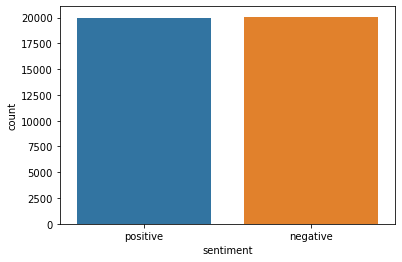

In [6]:
sns.countplot( x = 'sentiment', data = df );

## 3. Data Preprocessing

### 3.1 Label Encoding of Target Variable

Encode the target label sentiment.

In [7]:
# Encode the labels
le = LabelEncoder()
le.fit(df['sentiment'])
df['encoded_sentiments'] = le.transform(df['sentiment'])

### 3.2 Apply urduhack preprocessing
Now we will apply text cleaning modules from Urdu Hack Library

In [8]:
# Remove stop words from text
from typing import FrozenSet

# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset("""
 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())


def remove_stopwords(text: str):
    return " ".join(word for word in text.split() if word not in STOP_WORDS)

In [9]:
len(STOP_WORDS)

430

In [10]:
def preprocessing(text):
    text = normalize(text)
    text = ppro.normalize_whitespace(text)
    text = ppro.remove_punctuation(text)
    text = ppro.remove_accents(text)
    text = ppro.replace_urls(text)
    text = ppro.replace_emails(text)
    text = ppro.replace_phone_numbers(text)
    text = ppro.replace_numbers(text)
    text = ppro.replace_currency_symbols(text)
    text = ppro.remove_english_alphabets(text)    
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'<br />', ' ', text)
    text = remove_stopwords(text)
    text =  nltk.WordPunctTokenizer().tokenize(text)

    return text

In [11]:
df['cleaned'] = df['review'].apply(preprocessing)

Using publically available set of Urdu Text Stopwords we will remove stop words from our text.

In [12]:
# df['cleaned'] =  df['cleaned'].apply(remove_stopwords)

In [13]:
df

,review,sentiment,encoded_sentiments,cleaned
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,1,"[دہائی, وسط, کیبل, گائیڈ, اسکائینجر, ہنٹ, پہلو..."
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,0,"[دہائی, انسپکٹر, گیجٹ, کارٹون, پسند, فلم, دیکھ..."
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,1,"[معاشرے, حالت, تعجب, والد, پیدا, البرٹ, ٹی, فٹ..."
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,0,"[مفید, البرٹ, پیون, ردی, ٹوکری, گریڈ, زیڈ, جلد..."
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,1,"[کولمبو, ہدایتکاری, کیریئر, ابتدائی, وقت, اسٹی..."
...,...,...,...,...
39995,اگرچہ میں نے سب سے زیادہ تکنیکی طور پر اعلی در...,positive,1,"[زیادہ, تکنیکی, اعلی, درجے, فلم, دیکھی, تفریحی..."
39996,اس فلم نے مجھے حیرت سے دوچار کردیا۔ میں اسے عا...,positive,1,"[فلم, حیرت, دوچار, کردیا, عادت, بناتا, شرکت, ف..."
39997,مجھے افسوس ہے ، لیکن یہاں تک کہ ٹی جے ہوکر کے ...,negative,0,"[افسوس, ٹی, جے, ہوکر, ایڈرین, زیمڈ, نتیجہ, بچا..."
39998,اس فلم کو اکیڈمی کے ایوارڈ کے لئے نہیں سمجھا ج...,positive,1,"[فلم, اکیڈمی, ایوارڈ, سمجھا, فلم, لطف, اندوز, ..."


In [14]:
import json

from urduhack.config import LEMMA_LOOKUP_TABLE_PATH

_WORD2LEMMA = None

def lemma_lookup(text, lookup_path: str = LEMMA_LOOKUP_TABLE_PATH) -> list:
    tokens = text
    global _WORD2LEMMA
    if _WORD2LEMMA is None:
        with open(lookup_path, "r", encoding="utf-8") as file:
            _WORD2LEMMA = json.load(file)

    return [_WORD2LEMMA[word] if word in _WORD2LEMMA else word for word in tokens]

df['Lemmatized'] =list(map(lemma_lookup, df.cleaned))

In [15]:
# import deepdiff

In [16]:
# text = df["review"][0]
# text = preprocessing(text)

# nltk.WordPunctTokenizer().tokenize(text)


In [17]:
# lemmatizer = nltk.stem.WordNetLemmatizer()

In [18]:
# def lem(txt):
#     return [lemmatizer.lemmatize(t) for t in txt]

In [19]:
# txt1 = lemma_lookup(text)
# txt2 = lem(text)

# len(deepdiff.DeepDiff(txt1, text))
# len(deepdiff.DeepDiff(txt2, text))

In [20]:
# df[['review', 'Lemmatized']].head(10)

In [21]:
df.head()

,review,sentiment,encoded_sentiments,cleaned,Lemmatized
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,1,"[دہائی, وسط, کیبل, گائیڈ, اسکائینجر, ہنٹ, پہلو...","[دہائی, وسط, کیبل, گائیڈ, اسکائینجر, ہنٹ, پہلا..."
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,0,"[دہائی, انسپکٹر, گیجٹ, کارٹون, پسند, فلم, دیکھ...","[دہائی, انسپکٹر, گیجٹ, کارٹون, پسند, فلم, دیکھ..."
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,1,"[معاشرے, حالت, تعجب, والد, پیدا, البرٹ, ٹی, فٹ...","[معاشرہ, حالت, تعجب, والد, پیدا, البرٹ, ٹی, فٹ..."
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,0,"[مفید, البرٹ, پیون, ردی, ٹوکری, گریڈ, زیڈ, جلد...","[مفید, البرٹ, پیون, ردی, ٹوکری, گریڈ, زیڈ, جلد..."
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,1,"[کولمبو, ہدایتکاری, کیریئر, ابتدائی, وقت, اسٹی...","[کولمبو, ہدایتکاری, کیریئر, ابتدائی, وقت, اسٹی..."


### 4.3 Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Lemmatized'], df['encoded_sentiments'], test_size = 0.30, random_state = 7, shuffle = True)

In [23]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of Y_train', y_train.shape)
print('Shape of Y_test', y_test.shape)

Shape of X_train (28000,)
Shape of X_test (12000,)
Shape of Y_train (28000,)
Shape of Y_test (12000,)


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

## Model Train and Vectorization Class 

In [25]:
# class TrainModel:
#     def __init__(self, X_train, y_train, X_test, y_test):
#         self.bow_transform = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False) 
#         self.tfidf_transform = text.TfidfTransformer()
        
#         self.tfidf_train = self.bow_transform.fit_transform(X_train) 
#         self.tfidf_test = self.bow_transform.transform(X_test) 
        
#         self.X_tfidf_train = self.tfidf_transform.fit_transform(self.tfidf_train)
#         self.X_tfidf_test = self.tfidf_transform.transform(self.tfidf_test)
        
#         self.y_train = np.array(y_train)
#         self.y_test = np.array(y_test)
        
#         self.scores = []
#         self.best_estimators = {}
    
#     def _train(self, model, params, method, name):
#         try:
#             clf = GridSearchCV(model(), params, cv=5, return_train_score=False)
#             clf.fit(self.X_tfidf_train, self.y_train)

#             print("Mean Test Score")
#             print(self.get_mean_test_score(clf, params))
            
#             self.scores = [score for score in self.scores if score['model'] != (name)]
#             self.scores.append({
#                 'model': name,
#                 'best_score': clf.best_score_,
#                 'best_params': clf.best_params_
#             })

#             self.best_estimators[str(name)] = clf.best_estimator_
        
#         except Exception as e:
#             print("Exception : ", e)
        
#     def train(self, mlModel, params, modelName):        
#         print("\nTraining "+modelName+" using TFIDF Vectorization Method")
#         self._train(mlModel, params, "tfidf", modelName)
        
#         return self.best_estimators
    
#     def get_mean_test_score(self, clf, params):
#         keys = list(params.keys())
#         keys.append("mean_test_score")
#         df = pd.DataFrame([])
#         for x in keys:
#             df[x] = clf.cv_results_["param_"+keys[0]]
#         df["mean_test_score"] = clf.cv_results_["mean_test_score"]
#         return df
    
#     def getScore(self):
#         for score in self.scores:
#             print(score["model"], " : ", score["best_score"], " : ", score["best_params"])
    
#     def getClassificationReport(self):
#         for cls, best_estimator in self.best_estimators.items():
#             y_pred = best_estimator.predict(self.X_tfidf_test)
            
#             print(cls + " classification report:")
#             print(classification_report(self.y_test, y_pred))
            
#     def plotConfusionMatrix(self):        
#         fig, axes = plt.subplots(nrows=int(len(self.best_estimators.items())/2), ncols=3, figsize=(10, 15))
        
#         for cls, ax in zip(self.best_estimators.items(), axes.flatten()):
#             plot_confusion_matrix(
#                     cls[1], 
#                     self.X_tfidf_test,
#                     y_test, 
#                     ax=ax,
#                     cmap='Blues')

#             acc = round(cls[1].score(self.X_tfidf_test, y_test)*100, 2)
#             ax.title.set_text((cls[0]+" | "+ str(acc) + "%"))

#         plt.tight_layout()  
#         plt.show()

In [26]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False) 
tfidf_transform = text.TfidfTransformer()
        
tfidf_train = bow_transform.fit_transform(X_train) 
tfidf_test = bow_transform.transform(X_test) 
        
X_tfidf_train = tfidf_transform.fit_transform(tfidf_train)
X_tfidf_test = tfidf_transform.transform(tfidf_test)
        
y_train = np.array(y_train)
y_test = np.array(y_test)
        
scores = []
best_estimators = {}

In [27]:
def get_mean_test_score(clf, params):
    keys = list(params.keys())
    keys.append("mean_test_score")
    df = pd.DataFrame([])
    for x in keys:
        df[x] = clf.cv_results_["param_"+keys[0]]
    df["mean_test_score"] = clf.cv_results_["mean_test_score"]
    return df

def getScore( ):
    global scores
    for score in scores:
        print(score["model"], " : ", score["best_score"], " : ", score["best_params"])

def getClassificationReport( ):
    global best_estimators
    for cls, best_estimator in  best_estimators.items():
        y_pred = best_estimator.predict(X_tfidf_test)

        print(cls + " classification report:")
        print(classification_report(y_test, y_pred))

def plotConfusionMatrix( ):
    global best_estimators
    fig, axes = plt.subplots(nrows=int(len(best_estimators.items())/2), ncols=3, figsize=(15, 15))

    for cls, ax in zip(best_estimators.items(), axes.flatten()):
        plot_confusion_matrix(
                cls[1], 
                X_tfidf_test,
                y_test, 
                ax=ax,
                cmap='Blues')

        acc = round(cls[1].score(X_tfidf_test, y_test)*100, 2)
        ax.title.set_text((cls[0]+" | "+ str(acc) + "%"))

    plt.tight_layout()  
    plt.show()

In [28]:
def _train(model, params, name):
    try:
        clf = GridSearchCV(model(), params, cv=5, return_train_score=False)
        clf.fit(X_tfidf_train, y_train)

        global scores
        global best_estimators
        
        print("Mean Test Score")
        print(get_mean_test_score(clf, params))

        scores = [score for score in scores if score['model'] != (name)]
        scores.append({
            'model': name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })

        best_estimators[str(name)] = clf.best_estimator_

    except Exception as e:
        print("Exception : ", e)

In [59]:
# model = TrainModel(X_train, y_train, X_test, y_test)

## 5. Machine Learning Modeling

We will apply multiple machine learning models and compare the accuracies.

### 5.1 Support Vector Machine Classifier

In [29]:
params = {
    "max_iter": [100],
    'C': [0.1, 0.2, 0.3],
    'penalty' : ['l1', 'l2'],
#     'loss' : ['hinge'],
    'multi_class' : ['ovr', 'crammer_singer']
}

est = _train(svm.LinearSVC, params, "LinearSVC")

C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, y

Mean Test Score
   max_iter    C penalty multi_class  mean_test_score
0       100  100     100         100              NaN
1       100  100     100         100         0.859393
2       100  100     100         100         0.854643
3       100  100     100         100         0.854643
4       100  100     100         100              NaN
5       100  100     100         100         0.859643
6       100  100     100         100         0.857393
7       100  100     100         100         0.857393
8       100  100     100         100              NaN
9       100  100     100         100         0.859071
10      100  100     100         100         0.858214
11      100  100     100         100         0.858214


### 5.2 Logistic Regression Classifier

In [30]:
params = {
    'C': [40, 90, 95, 100],
    'solver' : ['liblinear'],
    'penalty' : ['l1', 'l2']
}
est = _train(LogisticRegression, params, "LogisticRegression")


Mean Test Score
     C solver penalty  mean_test_score
0   40     40      40         0.827143
1   40     40      40         0.844393
2   90     90      90         0.824821
3   90     90      90         0.840036
4   95     95      95         0.825036
5   95     95      95         0.840179
6  100    100     100         0.824571
7  100    100     100         0.839893


### 5.3 Decision Tree Classifier

In [31]:
params = {
    "max_depth" : [9], 
    "random_state" : [23],
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
}

est = _train(DecisionTreeClassifier, params, "Decision Tree")

Mean Test Score
  max_depth random_state criterion splitter  mean_test_score
0         9            9         9        9         0.714500
1         9            9         9        9         0.692536
2         9            9         9        9         0.711857
3         9            9         9        9         0.685643


### 5.4 Xgboost Classifier

In [84]:
params = {
#     "colsample_bytree" : [0.2],
#     "learning_rate" : [0.01, 0.1, 1],
    "n_estimators": [100, 120]
}

est = _train(xgb.XGBClassifier, params, "XGBoost")


KeyboardInterrupt



### 5.5 Random Forest Classifier

In [33]:
params = {
    "max_depth" : [9], 
    "random_state" : [43],
    "n_estimators": [450],
}

est = _train(RandomForestClassifier, params, "Random Forest Classifier")

Mean Test Score
  max_depth random_state n_estimators  mean_test_score
0         9            9            9         0.820071


### 5.6 KNN
40 | 0.778857

In [36]:
from sklearn.neighbors import KNeighborsClassifier  

In [82]:
params = {
   "n_neighbors" : [20, 30, 40],
    "weights" : ['distance'],
    "algorithm" : ['auto']
}

_train(KNeighborsClassifier, params, "KNeighbours Classifier")

Mean Test Score
  n_neighbors weights algorithm  mean_test_score
0          20      20        20         0.767464
1          30      30        30         0.775000
2          40      40        40         0.778857


In [85]:
scores

[{'model': 'LinearSVC',
  'best_score': 0.8596428571428572,
  'best_params': {'C': 0.2,
   'max_iter': 100,
   'multi_class': 'ovr',
   'penalty': 'l2'}},
 {'model': 'LogisticRegression',
  'best_score': 0.8443928571428572,
  'best_params': {'C': 40, 'penalty': 'l2', 'solver': 'liblinear'}},
 {'model': 'Decision Tree',
  'best_score': 0.7145,
  'best_params': {'criterion': 'gini',
   'max_depth': 9,
   'random_state': 23,
   'splitter': 'best'}},
 {'model': 'Random Forest Classifier',
  'best_score': 0.8200714285714286,
  'best_params': {'max_depth': 9, 'n_estimators': 450, 'random_state': 43}},
 {'model': 'KNeighbours Classifier',
  'best_score': 0.7788571428571429,
  'best_params': {'algorithm': 'auto',
   'n_neighbors': 40,
   'weights': 'distance'}},
 {'model': 'XGBoost',
  'best_score': 0.8215714285714284,
  'best_params': {'n_estimators': 100}}]

### 5.7 Multinomial NB

In [39]:
from sklearn.naive_bayes import MultinomialNB

In [59]:
params = {
    "alpha": [1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
}
est = _train(MultinomialNB, params, "KNeighbours Classifier")

Mean Test Score
  alpha  mean_test_score
0   1.0         0.830000
1  1.25         0.830679
2   1.5         0.831143
3  1.75         0.831571
4     2         0.831607
5  2.25         0.831714
6   2.5         0.831286


## 6. Results - UrduHack and TF-IDF Vectorizer 

C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Muhammad_Haseeb\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2.

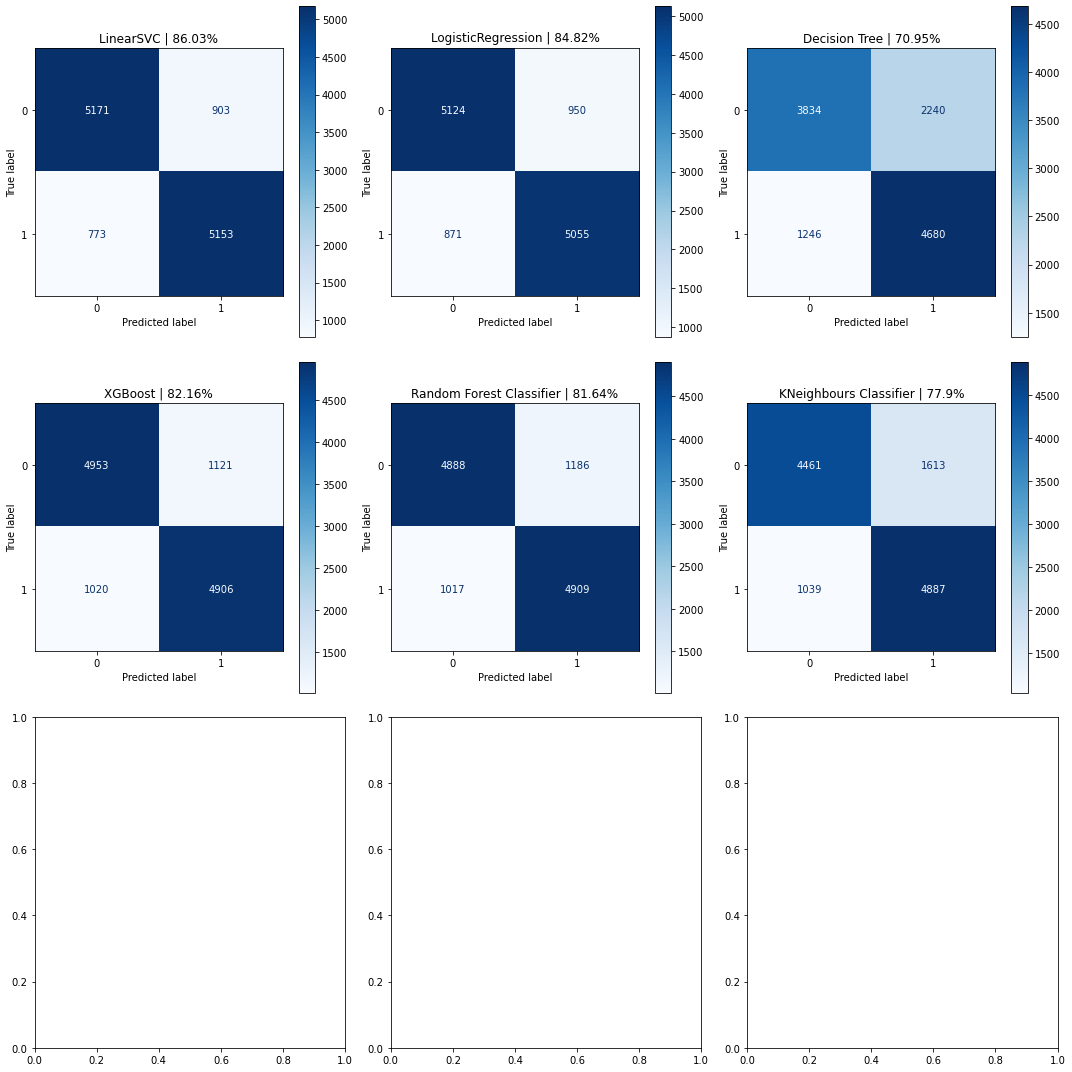

In [86]:
plotConfusionMatrix()

In [87]:
getClassificationReport()

LinearSVC classification report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      6074
           1       0.85      0.87      0.86      5926

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000

LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6074
           1       0.84      0.85      0.85      5926

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000

Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.75      0.63      0.69      6074
           1       0.68      0.79      0.73      5926

    accuracy                           0.71     12000
   macro avg    